In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# 선형 오토인코더로 PCA 수행하기

In [2]:
np.random.seed(4)
# 3D 데이터 만들기

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
X_train.shape

(60, 3)

In [4]:
from tensorflow import keras

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.1))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)
codings = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 1s 7ms/step - loss: 0.3019
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2836
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2667
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2520
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2370
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2234
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2098
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1968
Epoch 9/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1843
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1722
Epoch 11/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1605
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1498
Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.

In [6]:
codings.shape

(60, 2)

**3D 데이터를 가장 잘 투영하는 최상의 평면을 찾는 과정이다.**

# 적층 오토인코더
오토인코더도 다른 신경망과 마찬가지로 여러 은닉층을 가질 수 있다. 이런 경우를 stacked autoencoder(적층 오토인코더) 라고 한다.

그러나 오토인코더가 너무 강력해지지 않도록 조심해야한다. 오토인코더가 너무 강력해진다면 일반화 성능이 굉장히 낮아질 것 이기 때문이다.

In [7]:
# Mnist 데이터셋을 사용한다.

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [8]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])


# 재구성 작업을 할 때 BCE를 손실함수로 사용하는 이유는 픽셀이 검정일 확률을 찾는 것이기 때문이다.
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=1.5))

stacked_ae.fit(X_train, X_train, epochs=10,
              validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3374 - val_loss: 0.3178
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3049 - val_loss: 0.3015
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2981 - val_loss: 0.2981
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2941 - val_loss: 0.2940
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2914 - val_loss: 0.2914
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2894 - val_loss: 0.2897
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2878 - val_loss: 0.2889
Epoch 8/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2866 - val_loss: 0.2926
Epoch 9/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2857 - val_loss: 0.2871
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.28

In [9]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [10]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 62ms/step


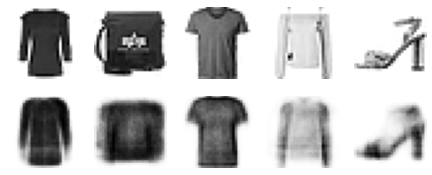

In [11]:
show_reconstructions(stacked_ae)

위 사진에서 첫번째가 원본이미지이고, 두번째가 재구성이미지이다. 

재구성이미지는 꽤나 많은 정보를 잃은 것을 볼 수 있다. 이는 모델을 더 오래 훈련하거나, 인코더와 디코더의 층을 늘리거나 코딩의 크기를 늘려야 할지 모른다. 하지만 네트워크가 너무 강력하면 데이터에서 어떤 유익한 패턴을 학습하지 못하고 완벽한 재구성이미지를 만들 것이다. 

# 패션 MNIST 데이터셋 시각화

stacked autoencoder를 훈련했으므로 이 모델을 사용해서 데이터셋의 차원을 축소할 수 있다. 시각화 입장에서 보면 다른 차원 축소 알고리즘만큼 좋은 결과를 주지 못한다. 하지만 오토인코더의 장점을 샘플과 특성이 많은 대용량 데이터셋을 다룰 수 있다는 점이다. 따라서 오토인코더를 사용해 적절한 수준으로 차원을 축소한 후 다른 차원 축소 알고리즘을 사용해 시각화하는 것도 좋은 방법이다. 이 방식으로 패션 MNIST 데이터를 시각화 해보자.

In [12]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


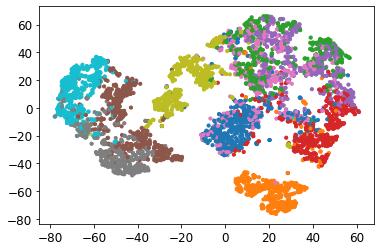

In [13]:
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=y_valid, s=10, cmap="tab10")

# 적층 오토인코더를 사용한 비지도 사전훈련

만약 지도학습 문제를 해결할 때 레이블된 훈련 데이터가 적다면, 이미 비슷한 문제를 학습한 모델의 하위 은닉층을 사용할 수 있다. 이는 저수준의 특성을 학습할 필요가 없다는 장점이 있다. 

비슷하게 레이블 되지 않은 대량의 데이터셋이 있다면 먼저 전체 데이터를 사용해 적층 오토 인코더를 훈련한다. 그 다음 오토인코더의 하위층을 재사용해서 실제 문제를 해결하기 위한 신경망을 만들고 레이블된 데이터를 사용해 훈련할 수 있다. 

훈련데이터가 많지 않다면 사전훈련된 층을 동결하는 것이 좋다.

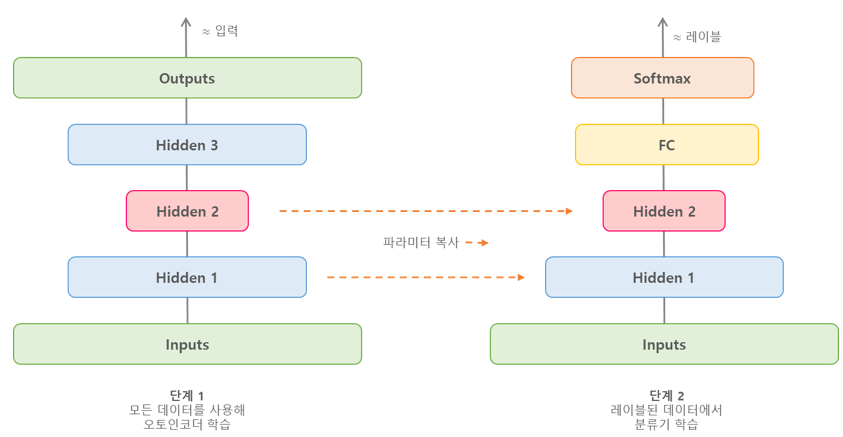

# 가중치 묶기 

방금 만든 것처럼 오토인코더가 완벽하게 대칭일 때는 디코더의 가중치와 인코더의 가중치를 묶는 것이 일반적인 방법이다. 이렇게 하면 모델에 있는 가중치의 수를 절반으로 줄여서 훈련속도를 높이고 과대적합의 위험을 줄여준다. 구체적인 예로 어떤 오토 인코더가 (입력층을 제외한) N개의 층을 갖고 W_L이 L번째 층의 가중치를 나타난다고 했을 때 디코더 층의 가중치는 W_N-L+1 = W_N^T 와 같이 간단하게 정리할 수 있다. 

케라스의 사용자 정의층을 만들어 층간에 가중치를 묶어보자

In [54]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        # 입력과 가중치의 전치를 곱하는 식
        # 디코더 층의 가중치는 W_N-L+1 = W_N^T 와 같이 정리할 수 있음...
        # 대신 편향은 따로 구한다.
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

위 층은 일반적인 Dense 층과 비슷하다. 하지만 다른 Dense 층의 전치된 가중치를 사용한다. 그리고 편향은 독자적으로 사용한다.

In [55]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    dense_1,
    dense_2                     
])
    
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28,28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

위 모델은 거의 절반의 파라미터로 이전 모델보다 약간 낮은 재구성 오차를 달성한다.

#  한 번에 오토인코더 한 개씩 훈련하기

앞서 만들었던 것 처럼 한 번에 전체 오토인코더를 훈련하는 것보다 오토인코더 하나를 훈련하고 이를 쌓아올려서 한개의 적층 오토인코도를 만들 수 있다. 이런 방식은 요즘엔 많이 사용하지 않지만 '탐욕적 방식의 층별 훈련 greedy layerwise training'에 대해서 이야기 하는 논문도 많기 때문에 알아두는 것이 좋다.

# 합성곱 오토인코더
이미지를 다루는 경우에는 이미지 크기가 작지 않은 이상 성능이 좋지 않기 때문에 CNN층을 사용한다.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)


# 인코더에서는 공간 방향의 차원(높이와 너비)은 줄이고. 깊이(특성 맵 개수)는 늘린다.
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])


# 디코더에서는 인코더에서 진행한 것과 반대로 작동시킨다.
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0))

history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

In [ ]:
conv_encoder.summary()
conv_decoder.summary()

# 순환 오토인코더
시계열이나 텍스트와 같은 시퀀스에 대한 오토인코더를 만들려면 순환신경망(RNN)이 밀집네트워크보다 좋을 수 있다.

In [ ]:
# 인코더는 sequence to vector RNN 이다.
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])

# 디코더는 vector to sequence RNN 이다.
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1))


history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

위 recurrent autoencoder는 타임스텝마다 28차원을 갖는 어떤 길이의 시퀀스를 처리할 수 있다. 편리하게도 이 말은 각 이미지를 행의 시퀀스로 간주하려 패션 MNIST 이미지를 처리할 수 있다는 뜻이다. 각 타임 스텝에서 이 RNN은 28픽셀의 행 하나를 처리한다. 당연히 어떤 종류의 시퀀스에도 순환 오토인코더를 사용할 수 있다. 타임스텝마다 입력 벡터를 주입하기 위해 디코더의 첫번째 츠에 RepeatVector 층을 사용한 점을 주목해보자.

위 오토인코더들은 undercomplete autoencoder 이다. 

이 아래부터는 입력 크기 만큼 또는 입력보다 큰 코딩층을 두어 overcomplete autoencoder를 만들어 보자

# 잡음 제거 오토인코더

# 희소 오토인코더

# 변이형 오토인코더